# Naive Bayes를 이용한 스팸 분류기
### (2014603043 최재익)

#### 전체적인 내용의 흐름은 다음과 같습니다.

* 주어진 Dataset을 다루기 쉬운 형태로 변환한다.
* 주어진 Dateset을 분류하는 Bernoulli Naive Bayes 모델을 제작한다.
* 제작한 모델과 sklearn의 모듈(BernoulliNB)의 결과를 비교한다.
* 주어진 Dataset을 분류하는 Multinomial Naive Bayes 모델을 제작한다.
* 제작한 모델과 sklearn의 모듈(MultinomialNB)의 결과를 비교한다.

#### 사용된 이론 및 방법들은 다음과 같습니다.
* Bayes' theorem
* Bag-of-words model
* Bernoulli document model
* Bernoulli NB smoothing
* Multinomial document model
* Multinomail NB smoothing (+log 변환)

#### 주어진 Dataset에 대한 가정은 다음과 같습니다.
* 입력 벡터를 구성하는 각각의 요소가 입력 벡터에 나타날 확률은 서로 '독립적'이다.

## 1. Dataset 다루기

* 사용된 Dataset은 과제와 함께 첨부하여 제출하였습니다.
* 올바른 작업경로에 Dataset을 저장한다면, 이후의 과정들을 직접 확인해볼 수 있습니다.

In [1]:
## Dataset from - https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
## Dataset을 다운로드한 후, "smsspamcollection.csv" 파일로 변환하였습니다.
## 작업경로를 현재 사용하는 경로로 지정하였습니다. (이 경로에 파일을 저장함.)
## 작업경로의 문제로 인한 오류 해결 방법 - https://codedragon.tistory.com/9343

import os

currentPath = os.getcwd()

os.chdir(currentPath + "\\.ipynb_checkpoints")

In [2]:
import pandas as pd

sms_collection = pd.read_csv('smsspamcollection.csv', encoding='latin1')
sms_collection.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### 불필요한 열을 삭제합니다.

In [3]:
del sms_collection['Unnamed: 2']
del sms_collection['Unnamed: 3']
del sms_collection['Unnamed: 4']

sms_collection.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### 열에 대한 이름을 다시 붙여줍니다.

In [4]:
# 'ham'을 '0'으로, 'spam'을 '1' 로 바꾸는 작업,'v1'을 'label', 'v2'를 'sms_message'로 바꾸는 작업을 진행

sms_collection.columns = ["label", "sms_message"]
sms_collection['label'] = sms_collection['label'].replace(['ham', 'spam'],[0,1])

sms_collection.head()

,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# 특정한 Index(예:4)에 대한 sms_message를 출력하는 방법

sms_collection.iloc[4]['sms_message']

"Nah I don't think he goes to usf, he lives around here though"

In [6]:
sms_collection

,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ? b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


#### 중복된 Data를 제거합니다.

In [7]:
# sms_message column을 기준으로, 맨 처음 중복 값을 남기고 나머지 중복 값은 제거

refined_sms_collection = sms_collection.drop_duplicates("sms_message", keep='first')
refined_sms_collection = refined_sms_collection.reset_index(drop=True)

In [8]:
refined_sms_collection

,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5164,1,This is the 2nd time we have tried 2 contact u...
5165,0,Will ? b going to esplanade fr home?
5166,0,"Pity, * was in mood for that. So...any other s..."
5167,0,The guy did some bitching but I acted like i'd...


#### 변환된 Dataset의 ham과 spam의 비율은 다음과 같습니다.

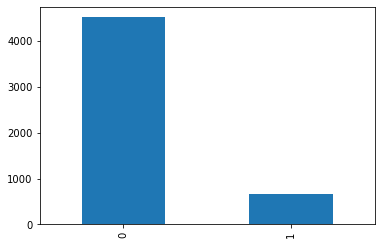

In [9]:
# 스팸 메일의 유무를 의미하는 label 값의 분포를 살펴보자. ('0'은 'ham', '1'은 'spam'을 의미)

refined_sms_collection['label'].value_counts().plot(kind='bar');

#### Dataset을 list의 형태로 변환합니다.

In [10]:
# sms_message를 모두 documents 리스트에 추가

documents = []

for i in range(len(refined_sms_collection)):
    documents.append(refined_sms_collection.iloc[i]['sms_message'])

In [11]:
documents[:5]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though"]

In [12]:
len(documents)

5169

#### 단어들을 숫자 벡터로 변환합니다.

In [13]:
# sklearn의 CountVectorizer모듈을 사용

from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

count_vector.fit(documents)
cv = count_vector.vocabulary_
cv

{'go': 3552,
 'until': 8032,
 'jurong': 4352,
 'point': 5922,
 'crazy': 2328,
 'available': 1304,
 'only': 5539,
 'in': 4089,
 'bugis': 1752,
 'great': 3636,
 'world': 8491,
 'la': 4478,
 'buffet': 1750,
 'cine': 2049,
 'there': 7647,
 'got': 3596,
 'amore': 1069,
 'wat': 8269,
 'ok': 5506,
 'lar': 4514,
 'joking': 4320,
 'wif': 8394,
 'oni': 5535,
 'free': 3360,
 'entry': 2951,
 'wkly': 8449,
 'comp': 2166,
 'to': 7758,
 'win': 8407,
 'fa': 3089,
 'cup': 2387,
 'final': 3209,
 'tkts': 7745,
 '21st': 411,
 'may': 4932,
 '2005': 402,
 'text': 7597,
 '87121': 784,
 'receive': 6299,
 'question': 6192,
 'std': 7232,
 'txt': 7935,
 'rate': 6244,
 'apply': 1156,
 '08452810075over18': 77,
 'dun': 2803,
 'say': 6635,
 'so': 7026,
 'early': 2824,
 'hor': 3929,
 'already': 1042,
 'then': 7642,
 'nah': 5240,
 'don': 2713,
 'think': 7662,
 'he': 3783,
 'goes': 3560,
 'usf': 8077,
 'lives': 4667,
 'around': 1207,
 'here': 3833,
 'though': 7682,
 'freemsg': 3367,
 'hey': 3843,
 'darling': 2444,
 'it

In [14]:
cv.keys()

dict_keys(['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'great', 'world', 'la', 'buffet', 'cine', 'there', 'got', 'amore', 'wat', 'ok', 'lar', 'joking', 'wif', 'oni', 'free', 'entry', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', '87121', 'receive', 'question', 'std', 'txt', 'rate', 'apply', '08452810075over18', 'dun', 'say', 'so', 'early', 'hor', 'already', 'then', 'nah', 'don', 'think', 'he', 'goes', 'usf', 'lives', 'around', 'here', 'though', 'freemsg', 'hey', 'darling', 'it', 'been', 'week', 'now', 'and', 'no', 'word', 'back', 'like', 'some', 'fun', 'you', 'up', 'for', 'still', 'tb', 'xxx', 'chgs', 'send', '50', 'rcv', 'even', 'my', 'brother', 'is', 'not', 'speak', 'with', 'me', 'they', 'treat', 'aids', 'patent', 'as', 'per', 'your', 'request', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam', 'has', 'set', 'callertune', 'all', 'callers', 'press', 'copy', 'friends', 'winner', 'valued', 'network', 'c

#### 각각의 문서들을 숫자 벡터로 변환합니다.

In [15]:
vector_doc_array = count_vector.transform(documents).toarray()
vector_doc_array

# 결과값이 0으로만 이루어진 것처럼 보이지만, 실제로는 그렇지 않다. (생략된 부분에서 0이 아닌 값들이 나온다.)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
vector_doc_array.size/len(cv)

5169.0

#### Dataset을 training set과 testing set으로 나누어 놓습니다.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(refined_sms_collection["sms_message"],refined_sms_collection['label'], random_state=1)

print("Our original set contains", refined_sms_collection.shape[0], "observations")
print("Our training set contains", X_train.shape[0], "observations")
print("Our testing set contains", X_test.shape[0], "observations")

Our original set contains 5169 observations
Our training set contains 3876 observations
Our testing set contains 1293 observations


In [19]:
X_train

1                           Ok lar... Joking wif u oni...
4982    I'm in inside office..still filling forms.don ...
3275    All day working day:)except saturday and sunday..
2727                        Smith waste da.i wanna gayle.
3558                      How r ? going to send it to me?
                              ...                        
2763    Ha. You donÛ? know either. I did a a clever b...
905          K, wait chikku..il send aftr  &lt;#&gt; mins
3980                              How much for an eighth?
235     U 447801259231 have a secret admirer who is lo...
5157                    Anything lor. Juz both of us lor.
Name: sms_message, Length: 3876, dtype: object

In [20]:
X_test

2971    I've been barred from all B and Q stores for l...
3830                  Gam gone after outstanding innings.
3066             Am okay. Will soon be over. All the best
3231    Welcome! Please reply with your AGE and GENDER...
2139    Alrite jod hows the revision goin? Keris bin d...
                              ...                        
3095    K actually can you guys meet me at the sunoco ...
2064                            So can collect ur laptop?
234     New Theory: Argument wins d SITUATION, but los...
2896    Please leave this topic..sorry for telling that..
1291                          Aight no rush, I'll ask jay
Name: sms_message, Length: 1293, dtype: object

In [21]:
y_train

1       0
4982    0
3275    0
2727    0
3558    0
       ..
2763    0
905     0
3980    0
235     1
5157    0
Name: label, Length: 3876, dtype: int64

In [22]:
y_test

2971    0
3830    0
3066    0
3231    1
2139    0
       ..
3095    0
2064    0
234     0
2896    0
1291    0
Name: label, Length: 1293, dtype: int64

#### X_train과 X_test를 다루기 쉬운 형태로 변환합니다.

In [23]:
X_train_array = count_vector.transform(X_train).toarray()
X_test_array = count_vector.transform(X_test).toarray()

In [24]:
X_train_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
X_test_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### 아래의 값들은 직접 제작한 모델에서 입력값으로 사용됩니다.

In [26]:
import numpy as np

class_set = np.unique(y_train)
class_count = np.zeros(class_set.size)

for i in range(class_set.size):
    
    count = 0
    
    for j in range(y_train.size):
        if class_set[i] == y_train.values[j]:
            count = count + 1
            
    class_count[i] = count

# 아래의 두 값은 '직접' 제작한 모델에서 입력값으로 사용

train_ham_size = int(class_count[0])
train_spam_size = int(class_count[1])

## 2. Bernoulli 모델을 '직접' 제작하기

#### Bernoulli 모델을 '직접' 제작하기 위해 사용되는 함수들은 다음과 같습니다.

In [27]:
## training set에 대한 ham과 spam의 개수를 구하는 함수

def B_class_count(y_train):
        
    class_set = np.unique(y_train)
    class_count = np.zeros(class_set.size)
    count_ham = 0
    count_spam = 0
        
    for i in range(y_train.size):
        if y_train.values[i] == 0:
            count_ham = count_ham + 1
        else:
            count_spam = count_spam + 1
                
    class_count[0] = count_ham
    class_count[1] = count_spam
        
    return class_count

In [28]:
## X_train의 ham에 대한 np.array를 구하는 함수

def B_ham_doc_list(train_ham_size, y_train, X_train_array):
        
    ham_doc_list = np.zeros((train_ham_size, len(cv)))
    ind = -1
        
    for i in range(y_train.size):
        if y_train.values[i] == 0:
            ind = ind + 1
            ham_doc_list[ind] = X_train_array[i]
                
    return ham_doc_list

In [29]:
## X_train의 spam에 대한 np.array를 구하는 함수

def B_spam_doc_list(train_spam_size, y_train, X_train_array):
        
    spam_doc_list = np.zeros((train_spam_size, len(cv)))   
    ind = -1
        
    for i in range(y_train.size):
        if y_train.values[i] == 1:
            ind = ind + 1
            spam_doc_list[ind] = X_train_array[i]
                
    return spam_doc_list

In [30]:
## ham, spam 각각에 대한 단어의 개수를 구하는 함수

def B_count_words(ham_doc_list, spam_doc_list):
        
    count_words = np.zeros((2, ham_doc_list[0].size))
    feature_size = ham_doc_list[0].size
        
    for i in range(len(cv)):
        count = 0
        for j in range(int(ham_doc_list.size/feature_size)):
            if ham_doc_list[j][i] >= 1:
                count = count + 1
        count_words[0][i] = count
            
    for i in range(len(cv)):
        count = 0
        for j in range(int(spam_doc_list.size/feature_size)):
            if spam_doc_list[j][i] >= 1:
                count = count + 1
        count_words[1][i] = count
            
    return count_words

In [31]:
## 각각의 단어의 확률을 구하는 함수

def B_prob_count_words(count_words, train_ham_size, train_spam_size):
        
    prob_count_words = np.zeros((2, count_words[0].size))
    prob_count_words[0] = count_words[0]/train_ham_size
    prob_count_words[1] = count_words[1]/train_spam_size
        
    return prob_count_words

In [32]:
## smmothing 과정을 거친 후에, 각각의 단어의 확률을 구하는 함수
## 가중치는 k = 1 을 사용

def B_smooth_prob_count_words(count_words, train_ham_size, train_spam_size):
    
    smooth_prob_count_words = np.zeros((2, count_words[0].size))
    smooth_prob_count_words[0] = (count_words[0] + 1)/(train_ham_size + 2)
    smooth_prob_count_words[1] = (count_words[1] + 1)/(train_spam_size + 2)
    
    return smooth_prob_count_words

In [33]:
## 입력된 문서가 ham 인지 spam 인지 판정하는 함수

def B_evaluation_class(count_words, train_ham_size, train_spam_size, X_test_array, class_count):
        
    list = np.zeros((int(X_test_array.size/len(cv)), int(class_count.size)))
    p_H = train_ham_size/(train_ham_size + train_spam_size)
    p_S = train_spam_size/(train_ham_size + train_spam_size)
        
    for i in range(int(list.size/2)):
            
        sentence = X_test_array[i]
        sum_H = math.log(p_H)
            
        for j in range(B_prob_count_words[0].size):
            if sentence[j] == 1:
                sum_H = sum_H + math.log(B_prob_count_words[0][j])
            else:
                sum_H = sum_H + math.log(1 - B_prob_count_words[0][j])
                
        list[i][0] = math.exp(sum_H)
                
    for i in range(int(list.size/2)):
            
        sentence = X_test_array[i]
        sum_S = math.log(p_S)    
            
        for j in range(B_prob_count_words[1].size):
            if sentence[j] == 1:
                sum_S = sum_S + math.log(B_prob_count_words[1][j])
            else:
                sum_S = sum_S + math.log(1 - B_prob_count_words[1][j])

        list[i][1] = math.exp(sum_S)
    
    
    result_list = np.zeros((int(X_test_array.size/len(cv)), int(class_count.size)))
    
    for i in range(int(list.size/2)):
        real_H = list[i][0]/(list[i][0] + list[i][1])
        real_S = list[i][1]/(list[i][0] + list[i][1])
        
        result_list[i][0] = real_H
        result_list[i][1] = real_S
        
    return result_list

In [34]:
## smoothing된 확률을 이용하여, 입력된 문서가 ham 인지 spam 인지 판정하는 함수
## 가중치는 k = 1 을 사용

def B_smooth_evaluation_class(count_words, train_ham_size, train_spam_size, X_test_array, class_count):
        
    list = np.zeros((int(X_test_array.size/len(cv)), int(class_count.size)))
    p_H = train_ham_size/(train_ham_size + train_spam_size)
    p_S = train_spam_size/(train_ham_size + train_spam_size)
      
    for i in range(int(list.size/2)):
            
        sentence = X_test_array[i]
        sum_H = math.log(p_H)
            
        for j in range(B_smooth_prob_count_words[0].size):
            if sentence[j] == 1:
                sum_H = sum_H + math.log(B_smooth_prob_count_words[0][j])
            else:
                sum_H = sum_H + math.log(1 - B_smooth_prob_count_words[0][j])
                
        list[i][0] = math.exp(sum_H)
                
    for i in range(int(list.size/2)):
            
        sentence = X_test_array[i]
        sum_S = math.log(p_S)    
            
        for j in range(B_smooth_prob_count_words[1].size):
            if sentence[j] == 1:
                sum_S = sum_S + math.log(B_smooth_prob_count_words[1][j])
            else:
                sum_S = sum_S + math.log(1 - B_smooth_prob_count_words[1][j])

        list[i][1] = math.exp(sum_S)
    
    
    result_list = np.zeros((int(X_test_array.size/len(cv)), int(class_count.size)))
    
    for i in range(int(list.size/2)):
        real_H = list[i][0]/(list[i][0] + list[i][1])
        real_S = list[i][1]/(list[i][0] + list[i][1])
        
        result_list[i][0] = real_H
        result_list[i][1] = real_S
        
    return result_list

#### 직접 제작한 모델과 Sklearn의 BernoulliNB 모듈의 결과를 비교할 것입니다.
#### Sklearn의 모듈 BernoulliNB를 불러옵니다.

In [35]:
from sklearn.naive_bayes import BernoulliNB

sklearn_BernoulliNB = BernoulliNB()
sklearn_BernoulliNB.fit(X_train_array, y_train)

BernoulliNB()

#### 1. training set의 ham과 spam의 개수는 다음과 같습니다.

In [36]:
B_class_count = B_class_count(y_train)
B_class_count

array([3388.,  488.])

In [37]:
sklearn_BernoulliNB.class_count_

array([3388.,  488.])

#### 2. ham과 spam에 대한 각각의 단어의 개수는 다음과 같습니다.

In [38]:
B_ham_doc_list = B_ham_doc_list(train_ham_size, y_train, X_train_array)
B_spam_doc_list = B_spam_doc_list(train_spam_size, y_train, X_train_array)

In [39]:
B_count_words = B_count_words(B_ham_doc_list, B_spam_doc_list)
B_count_words

array([[ 0.,  0.,  1., ...,  1.,  1.,  0.],
       [ 4., 17.,  0., ...,  0.,  0.,  1.]])

In [40]:
sklearn_BernoulliNB.feature_count_

array([[ 0.,  0.,  1., ...,  1.,  1.,  0.],
       [ 4., 17.,  0., ...,  0.,  0.,  1.]])

#### 3. 각각의 단어에 대한 확률은 다음과 같습니다.

In [41]:
B_train_ham_size = int(B_class_count[0])
B_train_spam_size = int(B_class_count[1])

In [42]:
B_prob_count_words = B_prob_count_words(B_count_words, B_train_ham_size, B_train_spam_size)
B_prob_count_words

array([[0.        , 0.        , 0.00029516, ..., 0.00029516, 0.00029516,
        0.        ],
       [0.00819672, 0.03483607, 0.        , ..., 0.        , 0.        ,
        0.00204918]])

In [43]:
sklearn_BernoulliNB_fc = sklearn_BernoulliNB.feature_count_

In [44]:
sklearn_BernoulliNB_fc/np.repeat(sklearn_BernoulliNB.class_count_[:, np.newaxis], 8668, axis = 1)

array([[0.        , 0.        , 0.00029516, ..., 0.00029516, 0.00029516,
        0.        ],
       [0.00819672, 0.03483607, 0.        , ..., 0.        , 0.        ,
        0.00204918]])

#### 4. (smoothing 과정을 거친 후의) 각각의 단어에 대한 확률은 다음과 같습니다.

In [45]:
B_smooth_prob_count_words = B_smooth_prob_count_words(B_count_words, B_train_ham_size, B_train_spam_size)
B_smooth_prob_count_words

array([[0.00029499, 0.00029499, 0.00058997, ..., 0.00058997, 0.00058997,
        0.00029499],
       [0.01020408, 0.03673469, 0.00204082, ..., 0.00204082, 0.00204082,
        0.00408163]])

In [46]:
np.exp(sklearn_BernoulliNB.feature_log_prob_)

array([[0.00029499, 0.00029499, 0.00058997, ..., 0.00058997, 0.00058997,
        0.00029499],
       [0.01020408, 0.03673469, 0.00204082, ..., 0.00204082, 0.00204082,
        0.00408163]])

#### 5. 각각의 문서에 대한 'ham일 확률'과 'spam일 확률'은 다음과 같습니다.

In [47]:
import math

B_smooth_evaluation_class = B_smooth_evaluation_class(B_count_words, B_train_ham_size, B_train_spam_size, X_test_array, B_class_count)
B_smooth_evaluation_class

array([[9.99997528e-01, 2.47222704e-06],
       [1.00000000e+00, 8.62460433e-12],
       [1.00000000e+00, 8.15629382e-14],
       ...,
       [1.00000000e+00, 3.35025704e-10],
       [1.00000000e+00, 3.49311578e-12],
       [1.00000000e+00, 5.20550378e-15]])

In [48]:
sklearn_BernoulliNB.predict_proba(X_test_array)

array([[9.99998728e-01, 1.27228586e-06],
       [1.00000000e+00, 8.62460433e-12],
       [1.00000000e+00, 8.15629382e-14],
       ...,
       [1.00000000e+00, 3.35025704e-10],
       [1.00000000e+00, 3.49311578e-12],
       [1.00000000e+00, 5.20550378e-15]])

#### 참고 : smoothing 과정이 없는 경우, ValueError가 발생합니다. (값이 '0'이되는 경우가 존재하기 때문)

In [49]:
## 전체 코딩을 돌리게 되는 경우 이 단계에서 멈추게 되므로, 각주의 형태로 코딩을 적어두었습니다.

# B_evaluation_class = B_evaluation_class(B_count_words, B_train_ham_size, B_train_spam_size, X_test_array, B_class_count)
# B_evaluation_class

#### 참고 : sklearn의 BernoulliNB 모듈에서 smoothing 과정에 사용된 k의 값은 1입니다.

In [50]:
sklearn_BernoulliNB.alpha

1.0

## 3. Multinomial 모델을 '직접' 제작하기

#### Multinomial 모델을 '직접' 제작하기 위해 사용되는 함수들은 다음과 같습니다.

In [51]:
## training set에 대한 ham과 spam의 개수를 구하는 함수

def M_class_count(y_train):
    
    calss_set = np.unique(y_train)
    class_count = np.zeros(class_set.size)
    count_ham = 0
    count_spam = 0
    
    for i in range(y_train.size):
        if y_train.values[i] == 0:
            count_ham = count_ham + 1
        else:
            count_spam = count_spam + 1
    
    class_count[0] = count_ham
    class_count[1] = count_spam
    
    return class_count

In [52]:
## X_train의 ham에 대한 np.array를 구하는 함수

def M_ham_doc_list(train_ham_size, y_train, X_train_array):
    
    ham_doc_list = np.zeros((train_ham_size, len(cv)))
    ind = -1
    
    for i in range(y_train.size):
        if y_train.values[i] == 0:
            ind = ind + 1
            ham_doc_list[ind] = X_train_array[i]
            
    return ham_doc_list

In [53]:
## X_train의 spam에 대한 np.array를 구하는 함수

def M_spam_doc_list(train_spam_size, y_train, X_train_array):
    
    spam_doc_list = np.zeros((train_spam_size, len(cv)))
    ind = -1
    
    for i in range(y_train.size):
        if y_train.values[i] == 1:
            ind = ind + 1
            spam_doc_list[ind] = X_train_array[i]
            
    return spam_doc_list

In [54]:
## ham, spam 각각에 대한 단어의 개수를 구하는 함수

def M_count_words(ham_doc_list, spam_doc_list):
    
    count_words = np.zeros((2, ham_doc_list[0].size))
    feature_size = ham_doc_list[0].size
    
    for i in range(len(cv)):
        count = 0
        for j in range(int(ham_doc_list.size/feature_size)):
            count = count + ham_doc_list[j][i]
        count_words[0][i] = count
        
    for i in range(len(cv)):
        count = 0
        for j in range(int(spam_doc_list.size/feature_size)):
            count = count + spam_doc_list[j][i]
        count_words[1][i] = count
        
    return count_words

In [55]:
## 각각의 단어의 확률을 구하는 함수

def M_prob_count_words(count_words, train_ham_size, train_spam_size):
    
    prob_count_words = np.zeros((2, count_words[0].size))
    prob_count_words[0] = count_words[0]/train_ham_size
    prob_count_words[1] = count_words[1]/train_spam_size
    
    return prob_count_words

In [56]:
## smmothing 과정을 거친 후에, 각각의 단어의 확률을 구하는 함수
## 가중치는 k = 1 을 사용

def M_smooth_prob_count_words(count_words):
    
    smooth_prob_count_words = np.zeros((2, count_words[0].size))
    count_words = count_words + 1
    smooth_prob_count_words[0] = count_words[0]/np.sum(count_words[0])
    smooth_prob_count_words[1] = count_words[1]/np.sum(count_words[1])
    
    return smooth_prob_count_words

In [57]:
## 입력된 문서가 ham 인지 spam 인지 판정하는 함수

def M_smooth_evaluation_class(count_words, train_ham_size, train_spam_size, X_test_array, class_count):
    
    list = np.zeros((int(X_test_array.size/len(cv)), int(class_count.size)))
    p_H = train_ham_size/(train_ham_size + train_spam_size)
    p_S = train_spam_size/(train_ham_size + train_spam_size)
    
    for i in range(int(list.size/2)):
        
        sentence = X_test_array[i]
        sum_H = math.log(p_H)
        
        for j in range(M_prob_count_words[0].size):
            if sentence[j] == 1:
                sum_H = sum_H + math.log(B_prob_count_words[0][j])
            else:
                sum_H = sum_H + math.log(1 - B_prob_count_words[0][j])
                
        list[i][0] = math.exp(sum_H)
    
    for i in range(int(list.size/2)):
        
        sentence = X_test_array[i]
        sum_S = math.log(p_S)
        
        for j in range(M_prob_count_words[1].size):
            if sentence[j] == 1:
                sum_S = sum_S + math.log(M_prob_count_words[1][j])
            else:
                sum_S = sum_S + math.log(1 - M_prob_count_words[1][j])
        
        list[i][1] = math.exp(sum_S)
        
        
    result_list = np.zeros((int(X_test_array.size/len(cv)), int(class_count.size)))
    
    for i in range(int(list.size/2)):
        real_H = list[i][0]/(list[i][0] + list[i][1])
        real_S = list[i][1]/(list[i][0] + list[i][1])
        
        result_list[i][0] = real_H
        result_list[i][1] = real_S
        
    return result_list

In [58]:
## smoothing된 확률을 이용하여, 입력된 문서가 ham 인지 spam 인지 판정하는 함수
## 가중치는 k = 1 을 사용

def M_smooth_evaluation_class(count_words, train_ham_size, train_spam_size, X_test_array, class_count):
    
    list = np.zeros((int(X_test_array.size/len(cv)), int(class_count.size)))
    p_H = train_ham_size/(train_ham_size + train_spam_size)
    p_S = train_spam_size/(train_ham_size + train_spam_size)
    
    for i in range(int(list.size/2)):
        
        sentence = X_test_array[i]
        sum_H = math.log(p_H)
        
        for j in range(M_smooth_prob_count_words[0].size):
            if sentence[j] == 1:
                sum_H = sum_H + math.log(B_smooth_prob_count_words[0][j])
            else:
                sum_H = sum_H + math.log(1 - B_smooth_prob_count_words[0][j])
                
        list[i][0] = math.exp(sum_H)
    
    for i in range(int(list.size/2)):
        
        sentence = X_test_array[i]
        sum_S = math.log(p_S)
        
        for j in range(M_smooth_prob_count_words[1].size):
            if sentence[j] == 1:
                sum_S = sum_S + math.log(M_smooth_prob_count_words[1][j])
            else:
                sum_S = sum_S + math.log(1 - M_smooth_prob_count_words[1][j])
        
        list[i][1] = math.exp(sum_S)
        
        
    result_list = np.zeros((int(X_test_array.size/len(cv)), int(class_count.size)))
    
    for i in range(int(list.size/2)):
        real_H = list[i][0]/(list[i][0] + list[i][1])
        real_S = list[i][1]/(list[i][0] + list[i][1])
        
        result_list[i][0] = real_H
        result_list[i][1] = real_S
        
    return result_list

#### 직접 제작한 모델과 Sklearn의 MultinomialNB 모듈의 결과를 비교할 것입니다.
#### Sklearn의 모듈 MultinomialNB를 불러옵니다.

In [59]:
from sklearn.naive_bayes import MultinomialNB

sklearn_MultinomialNB = MultinomialNB()
sklearn_MultinomialNB.fit(X_train_array, y_train)

MultinomialNB()

#### 1. training set의 ham과 spam의 개수는 다음과 같습니다.

In [60]:
M_class_count = M_class_count(y_train)
M_class_count

array([3388.,  488.])

In [61]:
sklearn_MultinomialNB.class_count_

array([3388.,  488.])

#### 2. ham과 spam에 대한 각각의 단어의 개수는 다음과 같습니다.

In [62]:
M_ham_doc_list = M_ham_doc_list(train_ham_size, y_train, X_train_array)
M_spam_doc_list = M_spam_doc_list(train_spam_size, y_train, X_train_array)

In [63]:
M_count_words = M_count_words(M_ham_doc_list, M_spam_doc_list)
M_count_words

array([[ 0.,  0.,  1., ...,  1.,  1.,  0.],
       [ 4., 18.,  0., ...,  0.,  0.,  1.]])

In [64]:
sklearn_MultinomialNB.feature_count_

array([[ 0.,  0.,  1., ...,  1.,  1.,  0.],
       [ 4., 18.,  0., ...,  0.,  0.,  1.]])

#### 3. 각각의 단어에 대한 확률은 다음과 같습니다.

In [65]:
M_train_ham_size = int(M_class_count[0])
M_train_spam_size = int(M_class_count[1])

In [66]:
M_prob_count_words = M_prob_count_words(M_count_words, M_train_ham_size, M_train_spam_size)
M_prob_count_words

array([[0.        , 0.        , 0.00029516, ..., 0.00029516, 0.00029516,
        0.        ],
       [0.00819672, 0.03688525, 0.        , ..., 0.        , 0.        ,
        0.00204918]])

In [67]:
sklearn_MultinomialNB_fc = sklearn_MultinomialNB.feature_count_

In [68]:
sklearn_MultinomialNB_fc/np.repeat(sklearn_MultinomialNB.class_count_[:, np.newaxis], 8668, axis = 1)

array([[0.        , 0.        , 0.00029516, ..., 0.00029516, 0.00029516,
        0.        ],
       [0.00819672, 0.03688525, 0.        , ..., 0.        , 0.        ,
        0.00204918]])

#### 4. (smoothing 과정을 거친 후의) 각각의 단어에 대한 확률은 다음과 같습니다.

In [69]:
M_smooth_prob_count_words = M_smooth_prob_count_words(M_count_words)
M_smooth_prob_count_words

array([[1.90110454e-05, 1.90110454e-05, 3.80220908e-05, ...,
        3.80220908e-05, 3.80220908e-05, 1.90110454e-05],
       [2.47463499e-04, 9.40361297e-04, 4.94926998e-05, ...,
        4.94926998e-05, 4.94926998e-05, 9.89853997e-05]])

In [70]:
np.exp(sklearn_MultinomialNB.feature_log_prob_)

array([[1.90110454e-05, 1.90110454e-05, 3.80220908e-05, ...,
        3.80220908e-05, 3.80220908e-05, 1.90110454e-05],
       [2.47463499e-04, 9.40361297e-04, 4.94926998e-05, ...,
        4.94926998e-05, 4.94926998e-05, 9.89853997e-05]])

#### 5. 각각의 문서에 대한 'ham일 확률'과 'spam일 확률'은 다음과 같습니다.

In [71]:
import math

M_smooth_evaluation_class = M_smooth_evaluation_class(M_count_words, M_train_ham_size, M_train_spam_size, X_test_array, M_class_count)
M_smooth_evaluation_class

array([[1.00000000e+00, 7.76545382e-30],
       [9.83165211e-01, 1.68347889e-02],
       [1.00000000e+00, 4.75594762e-11],
       ...,
       [1.00000000e+00, 1.69136998e-28],
       [9.99999932e-01, 6.84273584e-08],
       [9.99999767e-01, 2.33052219e-07]])

In [72]:
sklearn_MultinomialNB.predict_proba(X_test_array)

array([[9.99999990e-01, 1.03241721e-08],
       [9.83986312e-01, 1.60136885e-02],
       [9.99997911e-01, 2.08850102e-06],
       ...,
       [9.99999985e-01, 1.51455183e-08],
       [9.99810349e-01, 1.89650619e-04],
       [9.99996857e-01, 3.14281479e-06]])

#### sklearn의 모듈에서는 더 정확한 계산값을 구하는 방법이 적용된 것 같습니다.

#### 참고 : smoothing 과정이 없는 경우, ValueError가 발생합니다. (값이 '0'이되는 경우가 존재하기 때문)

In [73]:
## 전체 코딩을 돌리게 되는 경우 이 단계에서 멈추게 되므로, 각주의 형태로 코딩을 적어두었습니다.

# M_evaluation_class = M_evaluation_class(M_count_words, M_train_ham_size, M_train_spam_size, X_test_array, M_class_count)
# M_evaluation_class

#### 참고 : sklearn의 MultinomialNB 모듈에서 smoothing 과정에 사용된 k의 값은 1입니다.

In [74]:
sklearn_MultinomialNB.alpha

1.0